# LangGraph RAG minimal example

This LangGraph example shows the capabilities of LLMs deciding on using custom-made tools for specific purposes. In this particular example, the LLM decides whether to call the retrieval function to process BORME information or not, and if so, generating an answer based on the retrieved information from the vector database.

This code shall not be used for production and it is based on the LangGraph tutorial about RAG apps: [Build a Retrieval Augmented Generation (RAG) App: Part 2](https://python.langchain.com/docs/tutorials/qa_chat_history/).

In [53]:
from dotenv import load_dotenv
from typing import Final, List, Tuple

load_dotenv()

True

In [50]:
from pymilvus import MilvusClient

COLLECTION_NAME: Final[str] = 'borme'

milvus_client: MilvusClient = MilvusClient(uri='milvus.db')

In [51]:
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

llm: AzureChatOpenAI = AzureChatOpenAI(model='gpt-4o')
embeddings: AzureOpenAIEmbeddings = AzureOpenAIEmbeddings(
    model='text-embedding-ada-002',
)

In [56]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [ ]:
from langchain_core.tools import tool


@tool(response_format='content_and_artifact')
def retrieve(query: str) -> Tuple[str, List[List[dict]]]:
    """Retrieve information related to a query regarding BORME actos inscritos"""
    query_vector: List[float] = embeddings.embed_query(query)
    search_res = milvus_client.search(
        collection_name=COLLECTION_NAME,
        data=[query_vector],
        limit=3,
        search_params={'metric_type': 'L2', 'params': {}},
        output_fields=['text']
    )

    return '\n'.join(res['entity']['text'] for res in search_res[0]), search_res

In [57]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


tools = ToolNode([retrieve])

def generate(state: MessagesState):
    """Generate answer."""
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    response = llm.invoke(prompt)
    return {"messages": [response]}

In [58]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

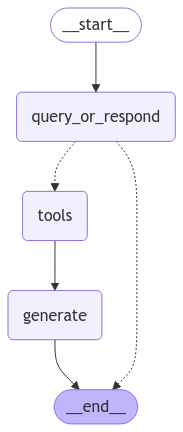

In [59]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
input_message = "Qué ha ocurrido de acuerdo a los actos inscritos en el BORME con Bazar Chrivan Sociedad Limitada?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Qué ha ocurrido de acuerdo a los actos inscritos en el BORME con Bazar Chrivan Sociedad Limitada?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_yBgfg6LCXn1MlZG1eB7Jr0ky)
 Call ID: call_yBgfg6LCXn1MlZG1eB7Jr0ky
  Args:
    query: Bazar Chrivan Sociedad Limitada BORME
================================= Tool Message =================================
Name: retrieve

517874 - BAZAR CHRIVAN SOCIEDAD LIMITADA.
Ceses/Dimisiones.  Adm. Unico: CALERO GOMEZ FRANCISCA. Liquidador: CALERO GOMEZ FRANCISCA.  Nombramientos.
Liquidador: CALERO GOMEZ FRANCISCA.  Disolución.  Voluntaria.  Extinción.  Datos registrales. S 8 , H AB 26790, I/A 3
(25.11.24).
517875 - DESARROLLOS SOLARES HISPANIA SOCIEDAD LIMITADA.
Ceses/Dimisiones.  Adm. Solid.: VILLAR DOMENECH DAVID;BAUTISTA CABAÑERO ALBERTO.  Nombramientos.  Adm. Unico:
edificios, locales comerciales, viviendas. L